In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
from scipy.spatial import KDTree
import tracemalloc
import time

# Generate random dataset
def generate_random_dataset(N, D):
    return np.random.randn(N, D)

In [2]:
# Naive KNN implementation
class NaiveKNN:
    def __init__(self, train_data):
        self.train_data = train_data

    def query(self, test_point, K):
        distances = np.sqrt(np.sum((self.train_data - test_point)**2, axis=1))
        nearest_indices = np.argsort(distances)[:K]
        return nearest_indices


In [4]:
def naive_KNN(k, dataset, test_point):
  distances = []

  for i in range(len(dataset)):
    distance = np.sqrt(np.sum((dataset[i] - test_point)**2))
    distances.append((i, distance))
  sorted_distances = sorted(distances, key=lambda x: x[1])
  neighbors = [dataset[index] for (index, dist) in sorted_distances[:k]]

  return neighbors


def creating_bins(p, dataset):
    n, d = dataset.shape
    ones_mat = np.ones((n, 1))

    X = np.hstack([ones_mat, dataset])
    W = np.random.randn(d+1, p)

    H = X @ W > 0

    powers_of_two = (1 << np.arange(p-1, -1, -1))
    int_indices = H.dot(powers_of_two)

    hash_dict = {}
    for i in range(2**p):
        hash_dict[i] = []
    for i in range(n):
        index = int_indices[i]
        hash_dict[index].append(i)

    return W, hash_dict


def find_LSH_neighbors(dataset, test_point, p, k, W, hash_dict):
    n, d = dataset.shape
    ones = np.ones((n,1))
    X = np.hstack([ones, dataset])

    x = np.hstack([[1], test_point])
    h = x @ W > 0

    powers_of_two = (1 << np.arange(p-1, -1, -1))
    int_index = h.dot(powers_of_two)

    bucket_i = hash_dict[int_index]
    bucket = dataset[bucket_i]

    neighbors = naive_KNN(k, bucket, test_point)
    return neighbors


In [5]:
# KD-tree KNN implementation
class KDTreeKNN:
    def __init__(self, train_data):
        self.tree = KDTree(train_data)

    def query(self, test_point, K):
        distances, indices = self.tree.query(test_point, k=K)
        return indices

In [6]:
# Measure time taken for training and testing
def measure_time1(train_data, test_point, K):
    train_time = 0
    test_time = 0
    iter=1000
    for _ in range(iter):
      start_time = time.time()

      neighbors = naive_KNN(K, train_data, test_point)

      end_time = time.time()

      test_time += (end_time- start_time)
    test_time /= iter
    train_time = 0

    return train_time, test_time


def measure_time2(train_data, test_point, K):
    train_time = 0
    test_time = 0
    iter=1000
    for _ in range(iter):
      start_time = time.time()

      W, hash_dict = creating_bins(3, train_data)
      ckpt_1 = time.time()

      lsh_neighbors = find_LSH_neighbors(train_data, test_point, 3, K, W, hash_dict)

      end_time = time.time()

      train_time += (ckpt_1- start_time)
      test_time += (end_time- ckpt_1)
    train_time/=iter
    test_time /= iter

    return train_time, test_time


def measure_time3(model, train_data, test_point, K):
    start_time = time.time()
    KDTreeKNN(train_data=train_data)
    training_time = time.time() - start_time

    start_time = time.time()
    model.query(test_point, K)
    testing_time = time.time() - start_time

    return training_time, testing_time

In [7]:
def memory_usage_knn(train_data, test_point, K):
    tracemalloc.start()
    neighbors = naive_KNN(K, train_data, test_point)
    mem = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    return mem

def memory_usage_lsh(train_data, test_point, K):
    tracemalloc.start()
    W, hash_dict = creating_bins(3, train_data)
    lsh_neighbors = find_LSH_neighbors(train_data, test_point, 3, K, W, hash_dict)
    mem = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    return mem

def memory_usage_kd(train_data, test_point, K):
    tracemalloc.start()
    model = KDTreeKNN(train_data=train_data)
    model.query(test_point, K)
    mem = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    return mem

In [8]:
def visualize_missed_neighbors(dataset, true_nearest_points, found_nearest_points, test_point, K, title):
    plt.scatter(dataset[:, 0], dataset[:, 1], color='#3776ab', label='Dataset')
    plt.scatter(test_point[0], test_point[1], color='red', marker='x', label='Test Point')
    # missed_nearest_points = true_nearest_points[~np.isin(true_nearest_points, found_nearest_points).all(axis=1)]
    plt.scatter(true_nearest_points[:, 0], true_nearest_points[:, 1], color='orange', label='True Nearest Neighbors')
    plt.scatter(found_nearest_points[:, 0], found_nearest_points[:, 1], color='yellow', marker = "*", label='Found Nearest Neighbors')
    # plt.scatter(missed_nearest_points[:, 0], missed_nearest_points[:, 1], color='purple', label='Missed Nearest Neighbors')
    plt.title(title)
    plt.legend()
    plt.show()

def plot_knn(dataset, test_point, neighbors):
  plt.scatter(dataset[:, 0], dataset[:, 1], label='Data points')
  plt.scatter(test_point[0], test_point[1], label='Test point', c='red')
  plt.scatter(neighbors[:, 0], neighbors[:, 1], label='k nearest neighbors', c='yellow')
  plt.legend()
  plt.show()

def plot_lsh(W, dataset, test_point, lsh_neighbors):
  plt.scatter(dataset[:, 0], dataset[:, 1], label='Data points')
  plt.scatter(test_point[0], test_point[1], label='Test point', c='red')
  plt.scatter(lsh_neighbors[:, 0], lsh_neighbors[:, 1], label='LSH neighbors', c='yellow')

  for i in range(W.shape[1] - 1):
    plt.plot(np.arange(min(dataset[:, 0]), max(dataset[:, 0]), 0.1), W[:, i][0]+W[:, i][1]*np.arange(min(dataset[:, 0]), max(dataset[:, 0]), 0.1)+W[:, i][2]*np.arange(min(dataset[:, 0]), max(dataset[:, 0]), 0.1), linestyle='--', c='black')

  plt.plot(np.arange(min(dataset[:, 0]), max(dataset[:, 0]), 0.1), W[:, W.shape[1]-1][0]+W[:, W.shape[1]-1][1]*np.arange(min(dataset[:, 0]), max(dataset[:, 0]), 0.1)+W[:, W.shape[1]-1][2]*np.arange(min(dataset[:, 0]), max(dataset[:, 0]), 0.1), linestyle='--', c='black', label='Partitions')
  plt.ylim(top=2.5, bottom=-2.5)
  plt.title('LSH Partitions')
  plt.legend()
  plt.show()

Dataset Size: 100, Dimensions: 2
Naive KNN Training Time: 0
Naive KNN Testing Time: 0.0012309532165527344
LSH KNN Training Time: 0.00010359954833984375
LSH KNN Testing Time: 0.0003900790214538574
KD-tree KNN Training Time: 0.0001227855682373047
KD-tree KNN Testing Time: 0.0003342628479003906
Naive KNN Memory Usage: (320, 4640) bytes
LSH KNN Memory Usage: (2896, 13683) bytes
KD-tree KNN Memory Usage: (1784, 5888) bytes


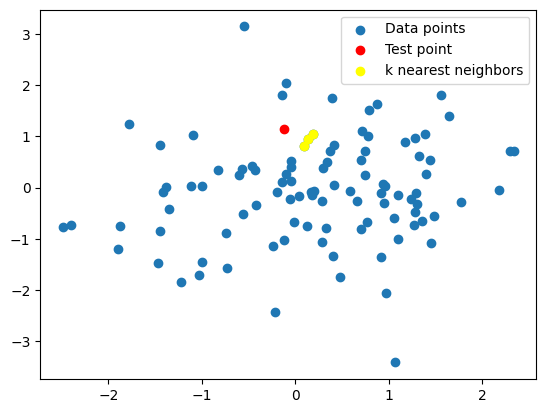

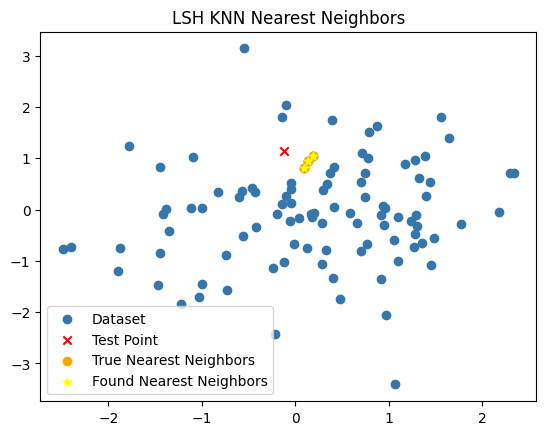

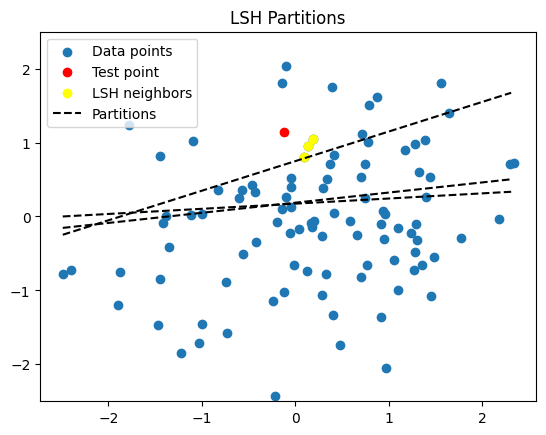

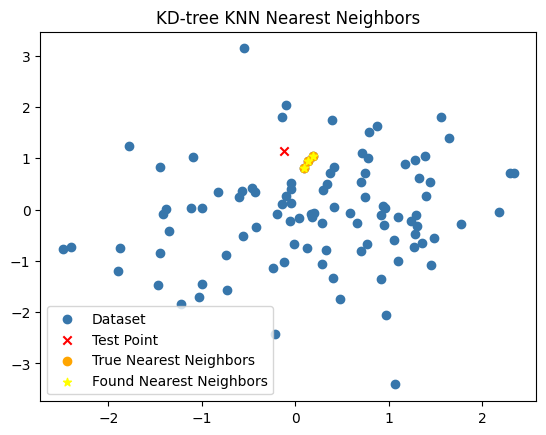

Dataset Size: 500, Dimensions: 2
Naive KNN Training Time: 0
Naive KNN Testing Time: 0.003663212537765503
LSH KNN Training Time: 0.0002485487461090088
LSH KNN Testing Time: 0.0012094671726226806
KD-tree KNN Training Time: 0.0002415180206298828
KD-tree KNN Testing Time: 0.00013494491577148438
Naive KNN Memory Usage: (320, 35156) bytes
LSH KNN Memory Usage: (14020, 39560) bytes
KD-tree KNN Memory Usage: (4968, 9336) bytes


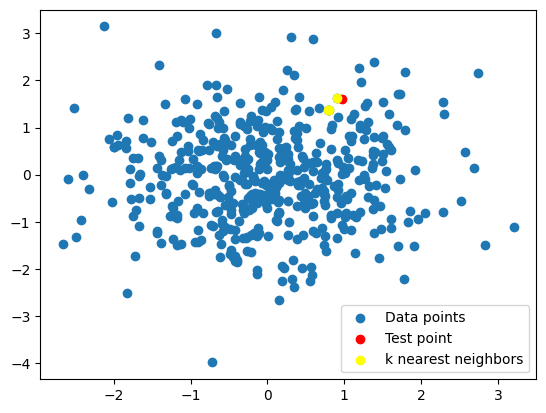

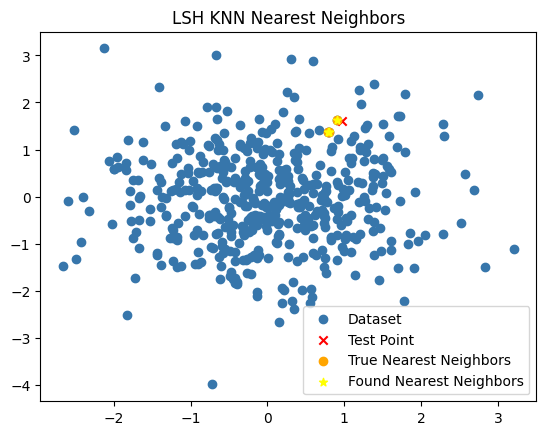

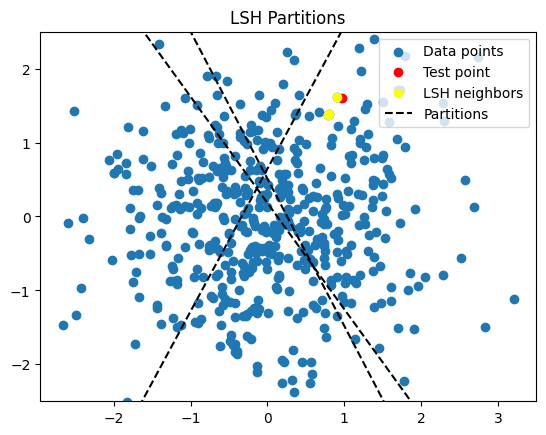

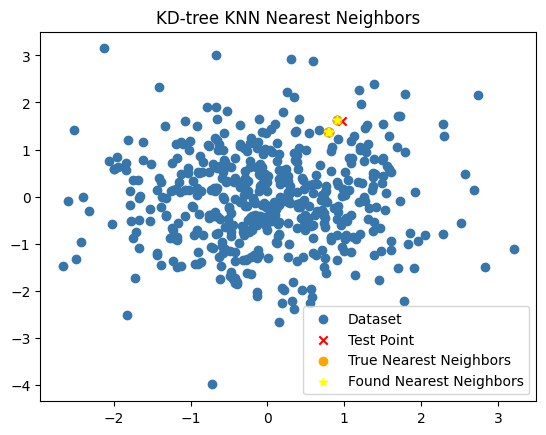

Dataset Size: 1000, Dimensions: 2
Naive KNN Training Time: 0
Naive KNN Testing Time: 0.008467010736465453
LSH KNN Training Time: 0.0004333477020263672
LSH KNN Testing Time: 0.0022357518672943117
KD-tree KNN Training Time: 0.0003192424774169922
KD-tree KNN Testing Time: 0.00010204315185546875
Naive KNN Memory Usage: (1106, 78566) bytes
LSH KNN Memory Usage: (35676, 89331) bytes
KD-tree KNN Memory Usage: (9304, 17336) bytes


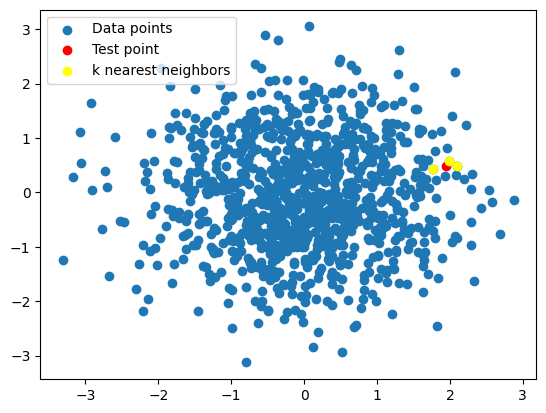

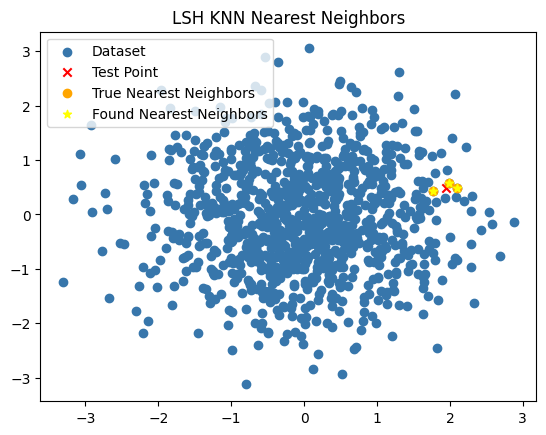

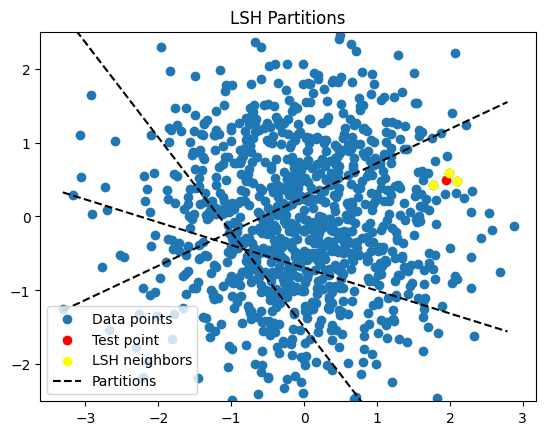

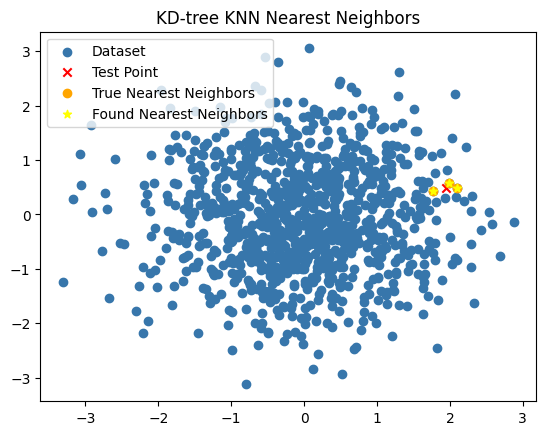

In [9]:
def main():
    N_values = [100, 500, 1000]
    D_values = [2]
    K = 3

    for N in N_values:
        for D in D_values:
            print(f"Dataset Size: {N}, Dimensions: {D}")
            # Generate dataset
            dataset = generate_random_dataset(N, D)

            # Generate test data
            test_data = np.random.randn(D)

            # Naive KNN
            neighbors_naive = naive_KNN(K, dataset, test_data)
            neighbors = np.array([list(neighbors_naive[0]), list(neighbors_naive[1]), list(neighbors_naive[2])])
            naive_training_time, naive_testing_time = measure_time1(dataset, test_data, K)
            print("Naive KNN Training Time:", naive_training_time)
            print("Naive KNN Testing Time:", naive_testing_time)

            # LSH KNN
            p = 3
            W, hash_dict = creating_bins(p, dataset)
            neighbors_lsh = find_LSH_neighbors(dataset, test_data, p, K, W, hash_dict)
            lsh_neighbors = np.array([list(neighbors_lsh[0]), list(neighbors_lsh[1]), list(neighbors_lsh[2])])
            lsh_training_time, lsh_testing_time = measure_time2(dataset, test_data, K)
            print("LSH KNN Training Time:", lsh_training_time)
            print("LSH KNN Testing Time:", lsh_testing_time)

            # KD-tree KNN
            kdtree_model = KDTreeKNN(train_data=dataset)
            kdtree_training_time, kdtree_testing_time = measure_time3(kdtree_model, dataset, test_data, K)
            print("KD-tree KNN Training Time:", kdtree_training_time)
            print("KD-tree KNN Testing Time:", kdtree_testing_time)


            naive_memory_usage = memory_usage_knn(dataset, test_data, K)
            lsh_memory_usage = memory_usage_lsh(dataset, test_data, K)
            kdtree_memory_usage = memory_usage_kd(dataset, test_data, K)

            print("Naive KNN Memory Usage:", naive_memory_usage, "bytes")
            print("LSH KNN Memory Usage:", lsh_memory_usage, "bytes")
            print("KD-tree KNN Memory Usage:", kdtree_memory_usage, "bytes")

            # Naive KNN
            # naive_nearest_indices = naive_model.query(test_data, K)
            plot_knn(dataset, test_data, neighbors)

            # LSH KNN
            # lsh_nearest_indices = lsh_model.query(test_data, K)
            visualize_missed_neighbors(dataset, neighbors, lsh_neighbors, test_data, K, 'LSH KNN Nearest Neighbors')
            plot_lsh(W, dataset, test_data, lsh_neighbors)

            # KD-tree KNN
            kdtree_nearest_indices = kdtree_model.query(test_data, K)
            kdtree_nearest_neighbors = dataset[kdtree_nearest_indices]
            visualize_missed_neighbors(dataset, neighbors, kdtree_nearest_neighbors, test_data, K, 'KD-tree KNN Nearest Neighbors')

if __name__ == "__main__":
    main()